### ASSIGNMENT 3 - Photometric Stereo

For this assignment we implemented/utilized/applied photometric stereo to extract or model 2D images of surfaces into 3D representations. 

The Lambertian model:
I_i ​= ρ (n ⋅ s_i​)

I_i = image intensity under light i
rho = albedo, reflectivity of the surface
n = surface normal
s_i = direction of the light i
n*s_i = the cosine between the normal vector and the light


If we have the intensities and the light directions, we can solve for m as a linear system. 

so we want the vector [m_x, m_y, m_z] = m for each pixel
and then ve stack these vectors and normalize to get the albedo. 



The LAmbertian does not not work well with specularities, so we use RANSAC to exclude outlier intensities




Each file:
- 3D array, I of size (m, n, k) 
    - where (m, n) = size of each image 
    - k is the number of views (i.e., view i corresponding to lighting si is I(:,:,i))

-  2D binary array mask of size (m, n). 
    - Pixels with values 1 (true) indicate positions where intensity data has been recorded. Photometric Stereo should only be solved at these points

- an array S of light vectors, of size (k, 3), where line i represents the directional light si that was used to obtain image I(:,:,i).

##### **4) SHINY VASE**

In [24]:
import ps_utils as ps
import numpy as np
import matplotlib.pyplot as plt
import random

In [25]:
shiny = ps.read_data_file('shiny_vase.mat')

img = shiny[0] #pixel intensities
mask = shiny[1] #mask values
S = shiny[2] #lighting directions

#reshape just in case, to filter for mask
img_flat = img.reshape(-1,3)
img_flat.shape

mask_flat = mask.flatten()
mask_flat.shape

J = img_flat[mask_flat==1,:]
J.shape #(24828,3)

(24828, 3)

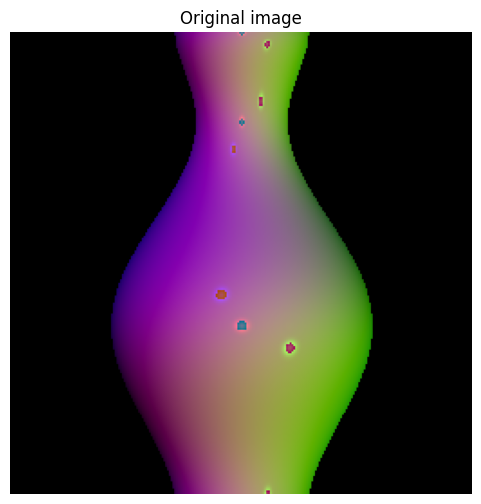

In [26]:
# one initial image
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Original image")
plt.axis('off')
plt.show()

In [27]:
S.shape

(3, 3)

In [28]:
#get m = rho*n - normally with Woodham
S_inverted = np.linalg.inv(S)

M = J @ S_inverted.transpose() #dotproduct of pixels and light directions
M[1] #each row is [rho*n_x, rho*n_y, rho*n_z] - I hope

#get albedo
rho = np.linalg.norm(M, axis = 1) #across rows

#get normals i.e. extract the albedo for each pixel
norm_vecs = M / rho[:,np.newaxis]
norm_vecs.shape

(24828, 3)

In [29]:
#map normal vecs and albedos back to image format (m,n)
norm_vecs.shape #(24828, 3)
rho.shape #(24828, )
#mask.shape # (256,256)
#mask_flat.shape #(65536,)


(24828,)

In [30]:

# OG dim to recreate image to 3D space
m,n = mask.shape

n_img = np.full((m, n, 3), 0, dtype=np.float32) #fill with 0, placeholder
rho_img = np.full((m, n), 0, dtype=np.float32)

# Remap normals and albedos into to their rightful place
idx = np.where(mask_flat == 1)[0] #ehre intensities are recorded
n_img.reshape(-1, 3)[idx] = norm_vecs 
rho_img.flatten()[idx] = rho

n1 = n_img[:, :, 0] #n_x
n2 = n_img[:, :, 1] #n_y
n3 = n_img[:, :, 2] #n_z

In [31]:
map = ps.simchony_integrate(n1, n2, n3, mask)
#ps.display_surface_matplotlib(np.ma.masked_invalid(map), albedo = None)
#dammit it still doesn't work unless I mask my array

c:\Users\admin\Desktop\VIP_assignment_3\DataAndCodeAssignment3\DataAndCodeAssignment3\ps_utils.py:526: RuntimeWarning: invalid value encountered in divide
  p = -n2/n3
c:\Users\admin\Desktop\VIP_assignment_3\DataAndCodeAssignment3\DataAndCodeAssignment3\ps_utils.py:527: RuntimeWarning: invalid value encountered in divide
  q = -n1/n3
c:\Users\admin\Desktop\VIP_assignment_3\DataAndCodeAssignment3\DataAndCodeAssignment3\ps_utils.py:557: RuntimeWarning: divide by zero encountered in divide
  Z = fs/denum


In [32]:
## RANSAC - obtain inliers only
 # J = valid pixels w intensities, S = light direction

ransac = np.full((J.shape), 0 , dtype=np.float32) #placeholder array 

#for each pixel
for i, pixel in enumerate(J):
    m, inliers, best_fit = ps.ransac_3dvector(data = (pixel,S),threshold=0.05, max_data_tries=100,
                                max_iters=1000, p=0.9, det_threshold=1e-1, verbose=0 )
    #m is the 3D vector, inliers is a list of indicies of inliers, best fit is best average for a model
    
    ransac[i,:] = m #append vector to placeholder array

#ransac

In [33]:
#re-extract albedo and norm vectors again for inliers only
rho_ransac = np.linalg.norm(ransac, axis=1)
norm_vecs_ran = ransac / rho_ransac[:, np.newaxis]

#norm_vecs_ran #looking beautiful

In [34]:
# remap again
m,n = mask.shape

n_img_ransac = np.full((m, n, 3), 0, dtype=np.float32)
rho_img_ransac = np.full((m, n), 0, dtype=np.float32)

idx = np.where(mask_flat == 1)[0] #ehre intensities are recorded
n_img_ransac.reshape(-1, 3)[idx] = norm_vecs_ran
rho_img_ransac.flatten()[idx] = rho_ransac

n1_ran = n_img_ransac[:, :, 0]
n2_ran = n_img_ransac[:, :, 1]
n3_ran = n_img_ransac[:, :, 2]


In [35]:
#RANSAC
depth_ran = ps.unbiased_integrate(n1_ran, n2_ran, n3_ran, mask)

c:\Users\admin\Desktop\VIP_assignment_3\DataAndCodeAssignment3\DataAndCodeAssignment3\ps_utils.py:604: RuntimeWarning: invalid value encountered in divide
  p = -n2/n3
c:\Users\admin\Desktop\VIP_assignment_3\DataAndCodeAssignment3\DataAndCodeAssignment3\ps_utils.py:605: RuntimeWarning: invalid value encountered in divide
  q = -n1/n3


In [36]:
#smooth normal field
n1_ran_s, n2_ran_s, n3_ran_s = ps.smooth_normal_field(n1_ran, n2_ran, n3_ran,mask = mask, iters=100, tau = 0.05, verbose = False)

In [37]:
#RANSAC & smoothed
depth_ran_s = ps.unbiased_integrate(n1_ran_s, n2_ran_s, n3_ran_s, mask)
#ps.display_surface((np.ma.masked_invalid(depth_ran)), albedo = None ) #still doesn't run no matter what I do

##### **PLOTS**

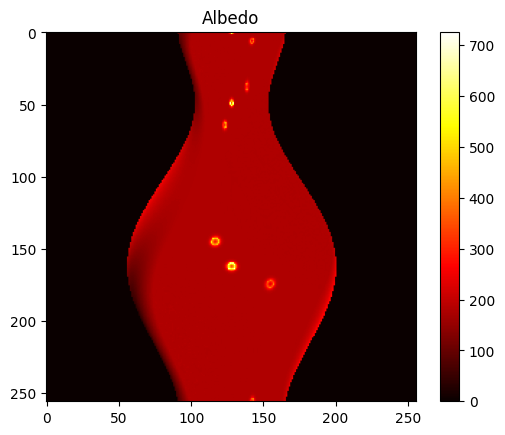

In [38]:
## 2D plot of albedo
rho_img = np.zeros(m * n)

rho_img[idx] = rho
rho_img = rho_img.reshape(m, n)

plt.figure()
plt.imshow(rho_img, cmap='hot')
plt.title("Albedo")
plt.colorbar()
plt.show()

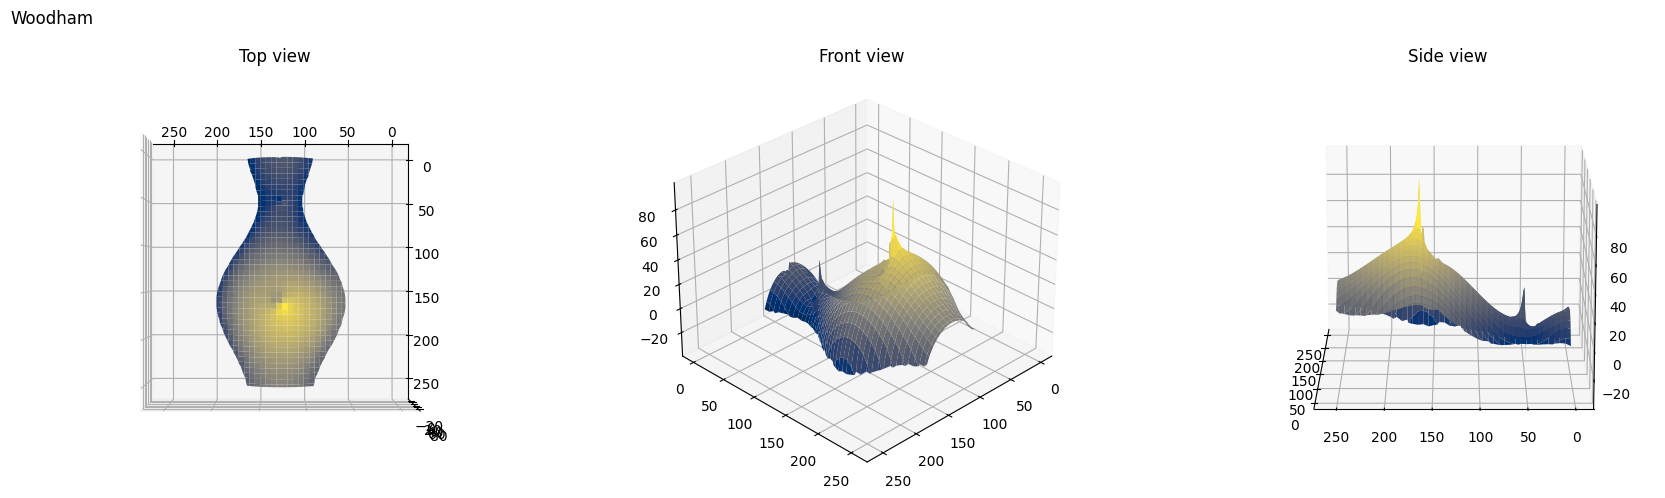

In [39]:
#Normal
fig = plt.figure(figsize=(18, 5))

Y, X = np.mgrid[0:m, 0:n]

# View 1: Top-down
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, map, cmap='cividis', linewidth=0)
ax1.view_init(elev=90, azim=90)
ax1.set_title("Top view")

# View 2: Front view
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, map, cmap='cividis', linewidth=0)
ax2.view_init(elev=30, azim=45)
ax2.set_title("Front view")

# View 3: Side view
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, map, cmap='cividis', linewidth=0)
ax3.view_init(elev=15, azim=180)
ax3.set_title("Side view")


fig.suptitle("Woodham", x = 0.05)
plt.tight_layout()
plt.show()

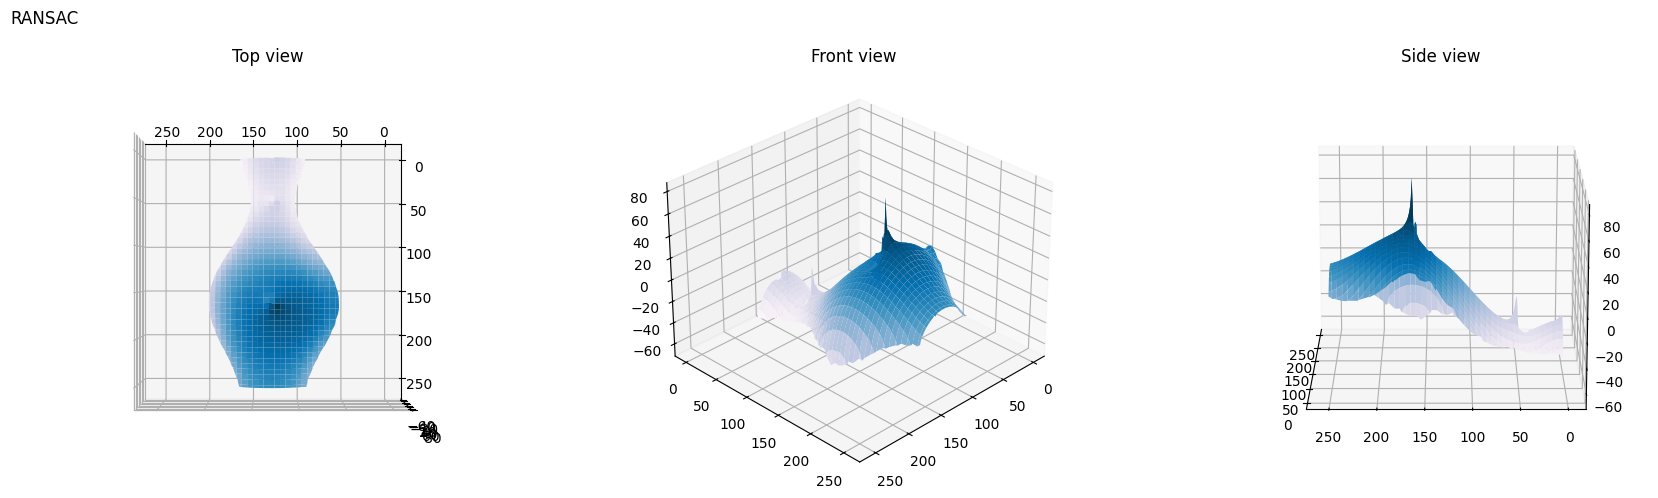

In [ ]:
fig = plt.figure(figsize=(18, 5))

Y, X = np.mgrid[0:m, 0:n]

# View 1: Top-down
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, depth_ran, cmap='PuBu', linewidth=0)
ax1.view_init(elev=90, azim=90)
ax1.set_title("Top view")

# View 2: Front view
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, depth_ran, cmap='PuBu', linewidth=0)
ax2.view_init(elev=30, azim=45)
ax2.set_title("Front view")

# View 3: Side view
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, depth_ran, cmap='PuBu', linewidth=0)
ax3.view_init(elev=15, azim=180)
ax3.set_title("Side view")


fig.suptitle("RANSAC", x = 0.05)
plt.tight_layout()
plt.show() #excludes some specuarities, but also excludes some valid file

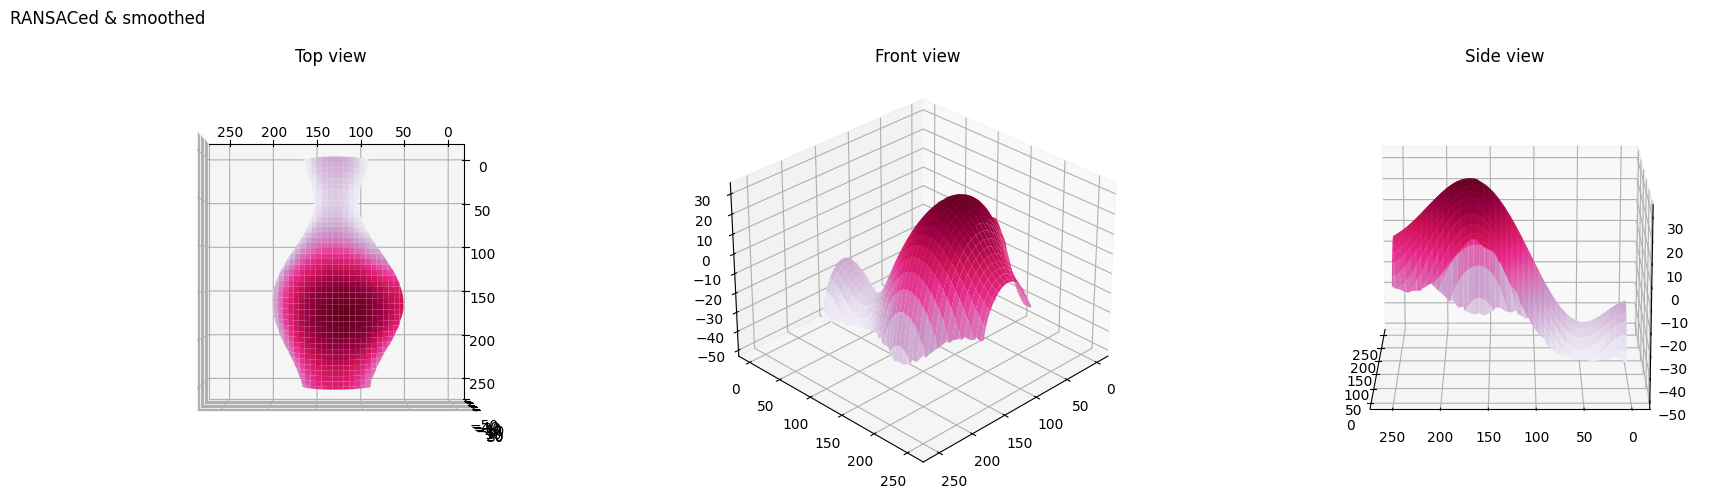

In [41]:
#RANSAC & smoothed
fig = plt.figure(figsize=(18, 5))

Y, X = np.mgrid[0:m, 0:n]

# View 1: Top-down
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, depth_ran_s, cmap='PuRd', linewidth=0)
ax1.view_init(elev=90, azim=90)
ax1.set_title("Top view")

# View 2: Front view
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, depth_ran_s, cmap='PuRd', linewidth=0)
ax2.view_init(elev=30, azim=45)
ax2.set_title("Front view")

# View 3: Side view
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, depth_ran_s, cmap='PuRd', linewidth=0)
ax3.view_init(elev=15, azim=180)
ax3.set_title("Side view")


fig.suptitle("RANSACed & smoothed", x = 0.05)
plt.tight_layout()
plt.show()

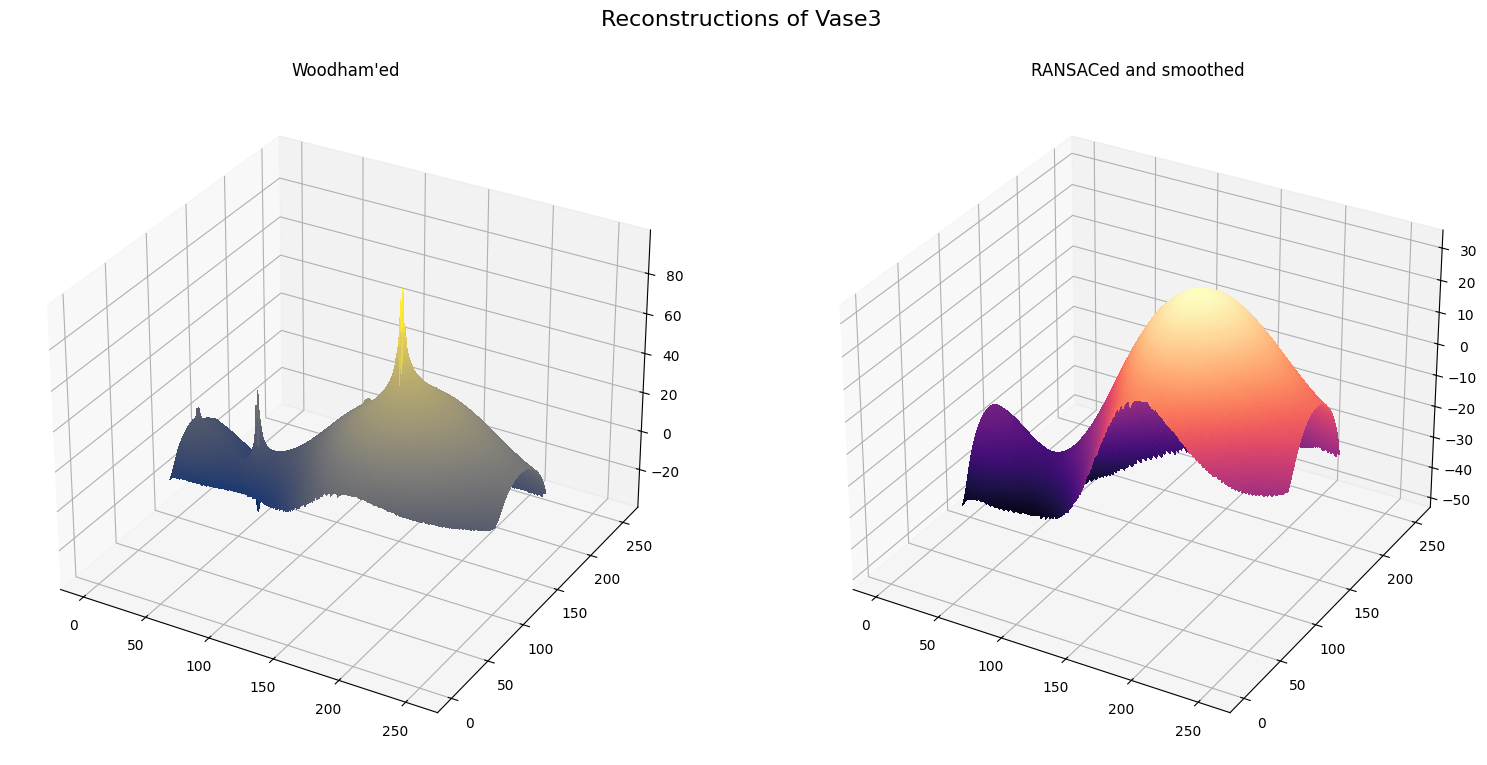

In [42]:
# other plotting 
z_clean_ran = np.ma.masked_invalid(depth_ran_s)
z_clean_w = np.ma.masked_invalid(map)
m, n = z_clean_ran.shape
x, y = np.mgrid[0:m, 0:n]

fig = plt.figure(figsize=(16, 8)) 
plt.suptitle("Reconstructions of Vase3", fontsize=16)

#Baseline vase
ax1 = fig.add_subplot(1, 2, 1, projection='3d') 

ax1.plot_surface(x, y, z_clean_w, 
                 rstride=1, 
                 cstride=1, 
                 cmap='cividis', 
                 linewidth=0, 
                 antialiased=False)

ax1.set_title("Woodham'ed")


#RANSAC vase
ax2 = fig.add_subplot(1, 2, 2, projection='3d') 

ax2.plot_surface(x, y, z_clean_ran, 
                 rstride=1, 
                 cstride=1, 
                 cmap='magma',
                 linewidth=0, 
                 antialiased=False)

ax2.set_title("RANSACed and smoothed")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

__________________________________________________________________________________________

##### **5) SHINY VASE2**

In [43]:
shiny22 = ps.read_data_file('shiny_vase2.mat') #contains 22 images

img22 = shiny22[0] #pixel intensities
mask22 = shiny22[1] #mask values
S22 = shiny22[2] #lighting directions

#reshape just in case, to filter for mask
img_flat22 = img22.reshape(-1,22)
img_flat22.shape

mask_flat22 = mask22.flatten()
mask_flat22.shape

J22 = img_flat22[mask_flat22==1,:]
J22.shape #(24828,22)
S22.shape

(22, 3)

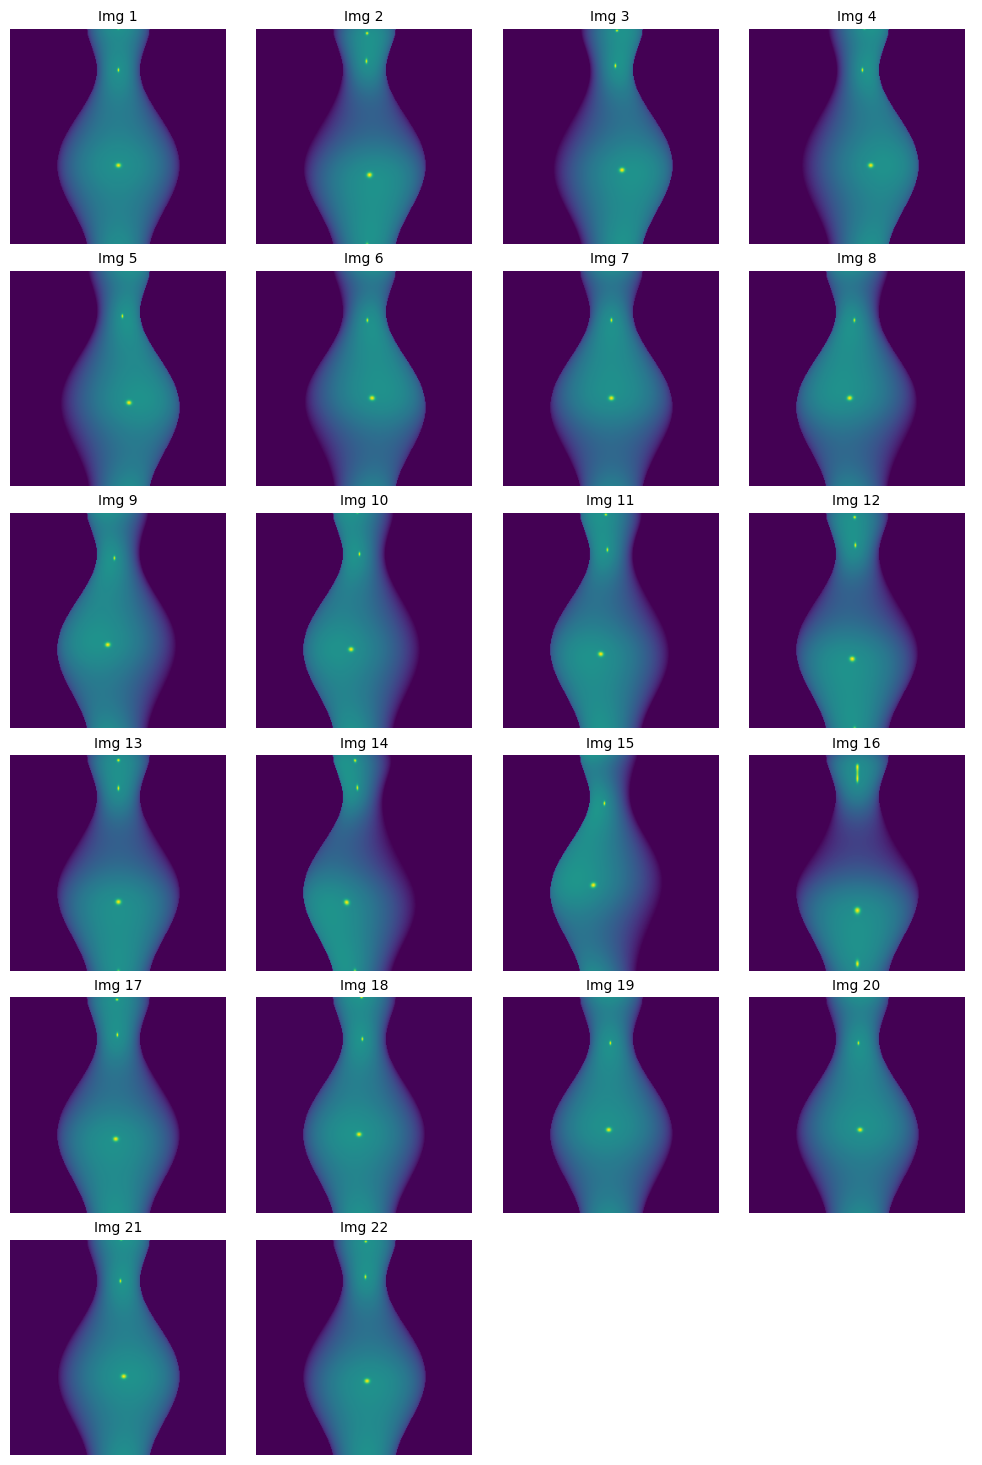

In [44]:
# the vase in different light
fig, axs = plt.subplots(6, 4, figsize=(10, 16))
axss = axs.flatten()

for i in range(22):
    ax = axss[i]
    ax.imshow(img22[:, :, i])
    ax.set_title(f"Img {i+1}", fontsize=10)
    ax.axis('off')

for j in range(22, 6* 4):
    axss[j].axis('off') #remove the two last ones

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### **WOODHAM**

In [45]:
##  GET ALBEDO + normal vectors
S_inverted22 = np.linalg.pinv(S22) #use pseudo-inverse bc S is (22,3)
S_inverted22.shape #(3,22)

M22 = J22 @ S_inverted22.transpose()  #for all pixels at once

#get albedo
rho22 = np.linalg.norm(M22, axis = 1) #as before, 

#get normals i.e. extract the albedo for each pixel
norm_vecs22 = M22 / rho22[:, np.newaxis] 
norm_vecs22

array([[-9.51126138e-01, -5.44120403e-03,  3.08754695e-01],
       [-9.34053036e-01,  3.16393762e-04,  3.57134184e-01],
       [-9.11291918e-01, -1.48303495e-03,  4.11758232e-01],
       ...,
       [ 8.64239845e-01,  2.03834533e-01,  4.59935837e-01],
       [ 8.79783220e-01,  2.11978225e-01,  4.25495850e-01],
       [ 8.95214551e-01,  2.05615582e-01,  3.95364566e-01]])

In [46]:
## Remap to img format

m22,n22 = mask22.shape #of same size as before

n_img22 = np.full((m22, n22, 3), np.nan) 
rho_img22 = np.full((m22, n22), np.nan)

# Remap normals and albedos into to their rightful place
idx22 = np.where(mask_flat22 == 1)[0] #where intensities are recorded
n_img22.reshape(-1,3)[idx22] = norm_vecs22 
rho_img22.flatten()[idx22] = rho22

n1 = n_img22[:, :, 0] #n_x
n2 = n_img22[:, :, 1] #n_y
n3 = n_img22[:, :, 2] #n_z

depth22 = ps.unbiased_integrate(n1, n2, n3, mask22)
#ps.display_surface_matplotlib(np.ma.masked_invalid(depth22), albedo = None)
#something is wrong or are 22 images enough to average out the specularities?

In [47]:
## RANSAC - takes forever to run
# threshold 0.05, 0.1, 1.5 - tight, medium, large 
# 0.05 took aaaaages to run, so I discarded that one 

ransac_01 = np.full((J22.shape[0],3), np.nan , dtype=np.float32)

#threshold 0.1 
for i, pixel in enumerate(J22): # if value is above or equal to threshold, then inlier (inconsistency in the ps.util code annotation)
    m, inliers, best_fit = ps.ransac_3dvector(data = (pixel,S22),threshold=0.1, max_data_tries=100,
                                max_iters=1000, p=0.9, det_threshold=1e-1, verbose=0 )
    
    ransac_01[i,:] = m 


In [48]:

#re-extract albedo and norm vectors again for inliers only
#0.1
rho_ransac01 = np.linalg.norm(ransac_01, axis=1)
norm_vecs_ran01 = ransac_01 / rho_ransac01[:, np.newaxis]

n_img_ransac01 = np.full((m22, n22, 3), np.nan, dtype=np.float32)
rho_img_ransac01 = np.full((m22, n22), np.nan, dtype=np.float32)

n_img_ransac01.reshape(-1, 3)[idx22] = norm_vecs_ran01
rho_img_ransac01.flatten()[idx22] = rho_ransac01

n1_ran01 = n_img_ransac01[:, :, 0]
n2_ran01 = n_img_ransac01[:, :, 1]
n3_ran01 = n_img_ransac01[:, :, 2]

#get depth
depth_01 = ps.unbiased_integrate(n1_ran01, n2_ran01, n3_ran01, mask22)
#ps.display_surface((np.ma.masked_invalid(depth_01)), albedo = None ) 

In [49]:
#smooth normal field
n1_ran_s, n2_ran_s, n3_ran_s = ps.smooth_normal_field(n1_ran01, n2_ran01, n3_ran01,mask = mask22, iters=1000, tau = 0.05, verbose = False)

In [50]:
#get new depth
depth_ran_s01 = ps.unbiased_integrate(n1_ran_s, n2_ran_s, n3_ran_s, mask22)
#ps.display_surface((np.ma.masked_invalid(depth_ran_s01)), albedo = None )

##### **PLOTS**

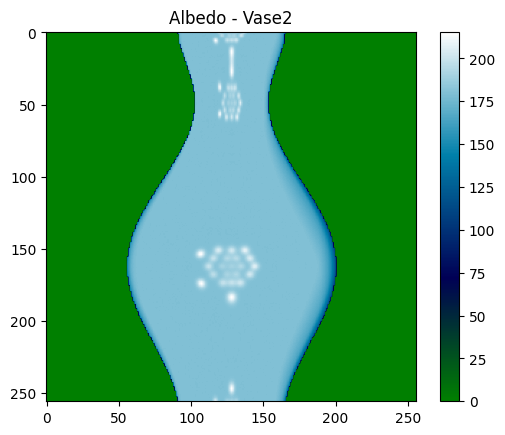

In [51]:
## 2D plot of albedo
rho_img = np.zeros(m22 * n22)

rho_img[idx22] = rho22
rho_img = rho_img.reshape(m22, n22)

plt.figure()
plt.imshow(rho_img, cmap='ocean')
plt.title("Albedo - Vase2")
plt.colorbar()
plt.show()

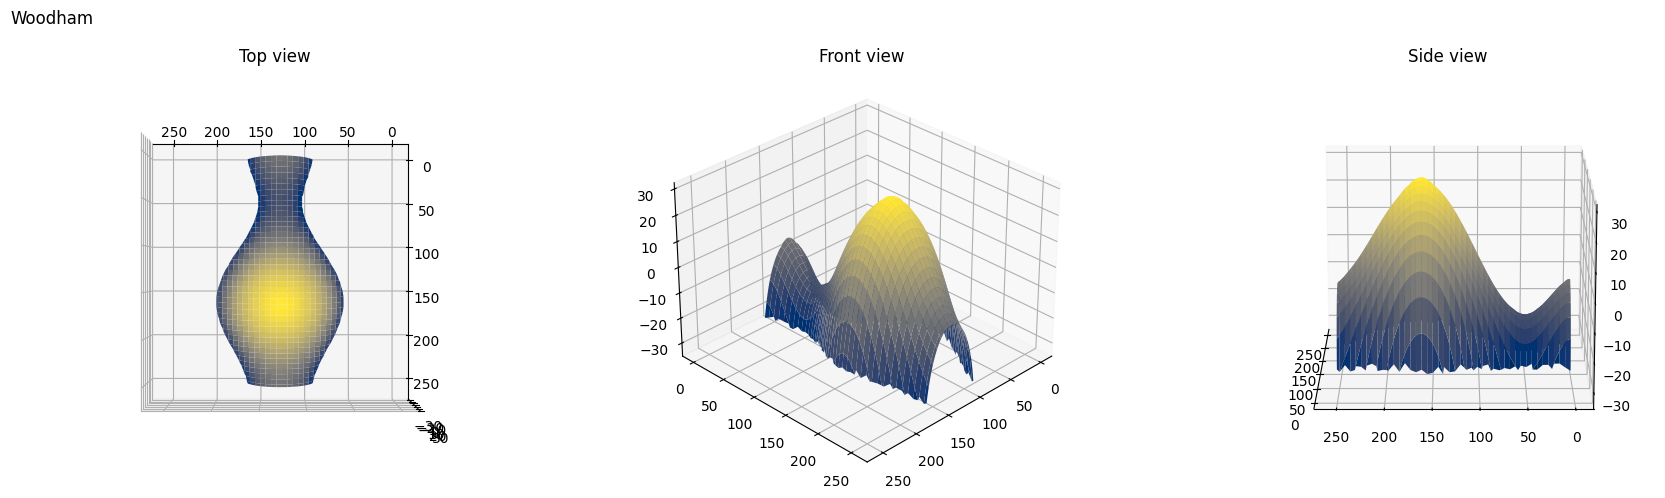

In [52]:
#WOODHAM
fig = plt.figure(figsize=(18, 5))

Y22, X22 = np.mgrid[0:m22, 0:n22]

# View 1: Top-down
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X22, Y22, depth22, cmap='cividis', linewidth=0)
ax1.view_init(elev=90, azim=90)
ax1.set_title("Top view")

# View 2: Front view
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X22, Y22, depth22, cmap='cividis', linewidth=0)
ax2.view_init(elev=30, azim=45)
ax2.set_title("Front view")

# View 3: Side view
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X22, Y22, depth22, cmap='cividis', linewidth=0)
ax3.view_init(elev=15, azim=180)
ax3.set_title("Side view")


fig.suptitle("Woodham", x = 0.05)
plt.tight_layout()
plt.show()

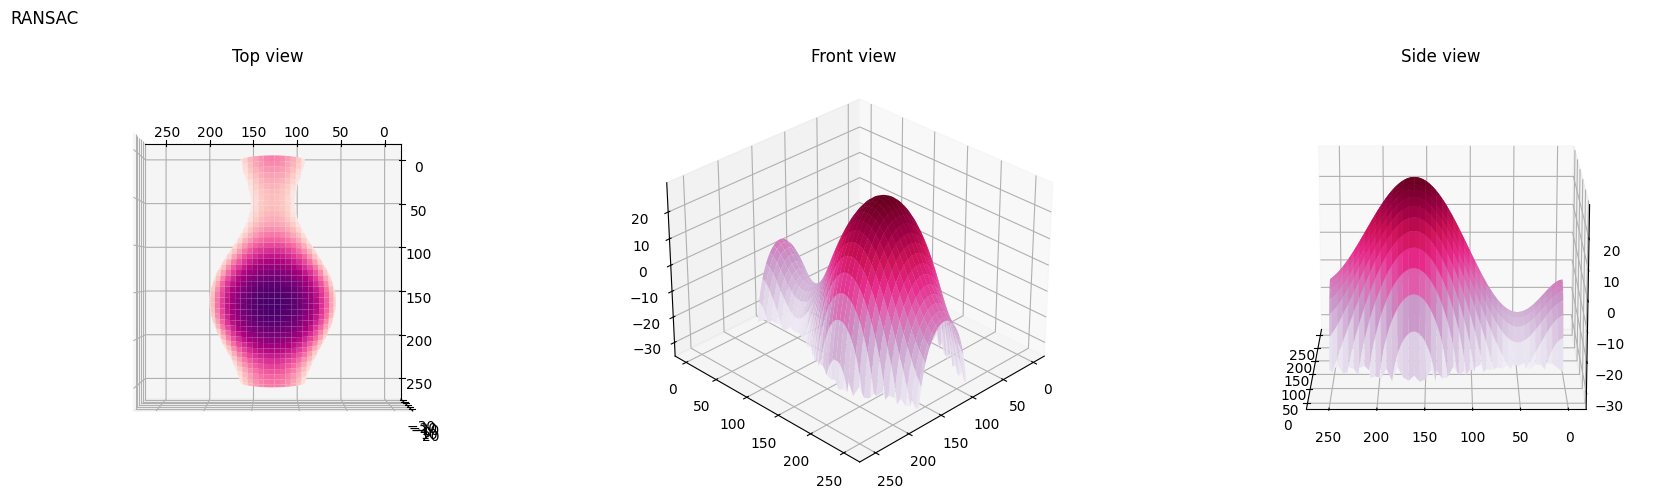

In [53]:
#RANSAC 0.1
fig = plt.figure(figsize=(18, 5))

# View 1: Top-down
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X22, Y22, depth_01, cmap='RdPu', linewidth=0)
ax1.view_init(elev=90, azim=90)
ax1.set_title("Top view")

# View 2: Front view
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X22, Y22, depth_01, cmap='PuRd', linewidth=0)
ax2.view_init(elev=30, azim=45)
ax2.set_title("Front view")

# View 3: Side view
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X22, Y22, depth_01, cmap='PuRd', linewidth=0)
ax3.view_init(elev=15, azim=180)
ax3.set_title("Side view")


fig.suptitle("RANSAC", x = 0.05)
plt.tight_layout()
plt.show()

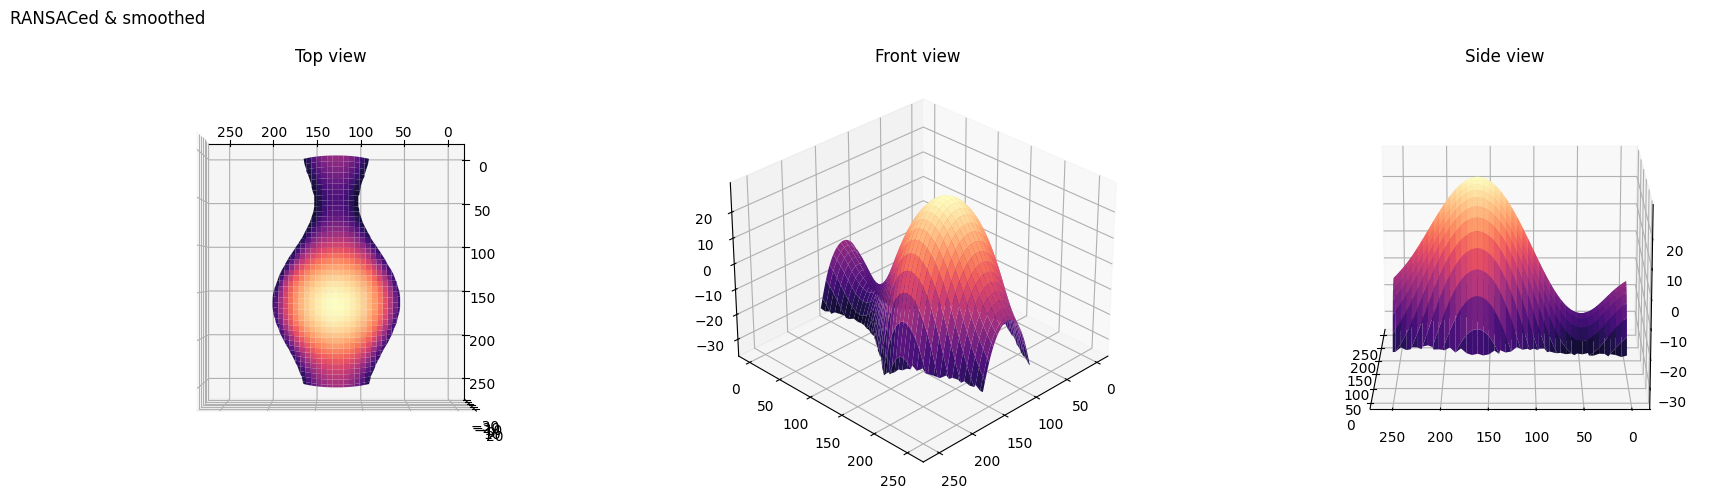

In [54]:
#RANSAC & smoothed - 0.3
fig = plt.figure(figsize=(18, 5))


# View 1: Top-down
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X22, Y22, depth_ran_s01, cmap='magma', linewidth=0)
ax1.view_init(elev=90, azim=90)
ax1.set_title("Top view")

# View 2: Front view
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X22, Y22, depth_ran_s01, cmap='magma', linewidth=0)
ax2.view_init(elev=30, azim=45)
ax2.set_title("Front view")

# View 3: Side view
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X22, Y22, depth_ran_s01, cmap='magma', linewidth=0)
ax3.view_init(elev=15, azim=180)
ax3.set_title("Side view")


fig.suptitle("RANSACed & smoothed", x = 0.05)
plt.tight_layout()
plt.show()

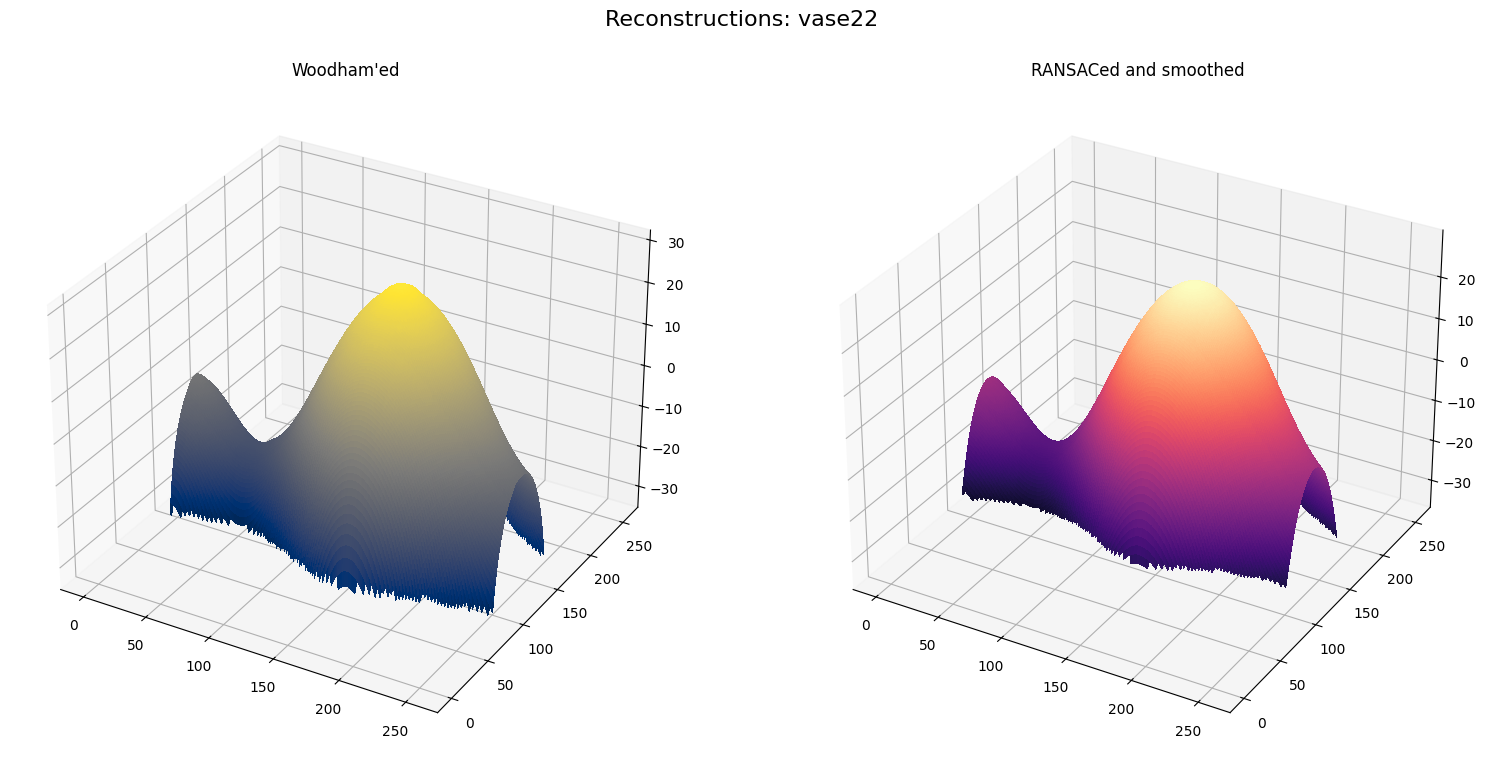

In [55]:
# other plotting 
z_clean_ran = np.ma.masked_invalid(depth_ran_s01) #RANSAC + smoothed
z_clean_w = np.ma.masked_invalid(depth22) #WOODHAM
m, n = z_clean_ran.shape
x, y = np.mgrid[0:m, 0:n]

fig = plt.figure(figsize=(16, 8)) 
plt.suptitle("Reconstructions: vase22", fontsize=16)

#Baseline vase
ax1 = fig.add_subplot(1, 2, 1, projection='3d') 

ax1.plot_surface(x, y, z_clean_w, 
                 rstride=1, 
                 cstride=1, 
                 cmap='cividis', 
                 linewidth=0, 
                 antialiased=False)

ax1.set_title("Woodham'ed")


#RANSAC vase
ax2 = fig.add_subplot(1, 2, 2, projection='3d') 

ax2.plot_surface(x, y, z_clean_ran, 
                 rstride=1, 
                 cstride=1, 
                 cmap='magma',
                 linewidth=0, 
                 antialiased=False)

ax2.set_title("RANSACed and smoothed")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()